<a href="https://colab.research.google.com/github/m-bashari-m/vehicle-color-recognition/blob/main/src/rgb_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Prepare utils file

!wget https://raw.githubusercontent.com/m-bashari-m/vehicle-color-recognition/main/src/utils.py

--2022-06-05 18:16:16--  https://raw.githubusercontent.com/m-bashari-m/vehicle-color-recognition/main/src/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9888 (9.7K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   9.66K  --.-KB/s    in 0s      

2022-06-05 18:16:17 (88.3 MB/s) - ‘utils.py.1’ saved [9888/9888]



In [1]:
from google.colab import drive
drive.mount('./drive')

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

from utils import ModelCreator, get_train_val_ds, ErrorAnalyzer, get_class_weight

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
AUTOTUNE = tf.data.AUTOTUNE
N_CLASSES = 16
HUB_URL = 'https://tfhub.dev/google/bit/m-r50x1/1'

In [4]:
dataset_dir = os.path.join('drive', 'MyDrive', 'cars')
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')

In [5]:
# Get shuffled train and validation dataset with one-hot labels

train_ds, val_ds = get_train_val_ds(train_dir, val_dir, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

Found 17043 files belonging to 16 classes.
Found 3495 files belonging to 16 classes.


In [6]:
# Get class weights which have calculated from the previous notebook and stored in github

classes, class_weight = get_class_weight()

In [ ]:
for color, weight in zip(classes, class_weight.values()):
  print(color, "    \t=>", weight)

beige     	=> 17.94
black     	=> 13.8
blue     	=> 15.47
brown     	=> 17.92
cream     	=> 56.81
crimson     	=> 76.43
gold     	=> 56.81
green     	=> 21.2
grey     	=> 12.41
navy-blue     	=> 58.77
orange     	=> 22.37
red     	=> 16.39
silver     	=> 20.17
titanium     	=> 56.81
white     	=> 2.97
yellow     	=> 20.68


In [7]:
train_ds = (
    train_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=AUTOTUNE).
    prefetch(AUTOTUNE))

val_ds = (
    val_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=AUTOTUNE).
    prefetch(AUTOTUNE))

In [8]:
rgb_creator = ModelCreator(HUB_URL, 'RGB-model')
rgb_model = rgb_creator.make_model(img_size=IMG_SIZE)

Model: "RGB-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 dense (Dense)               (None, 600)               1229400   
                                                                 
 dropout (Dropout)           (None, 600)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                9616      
                                                                 
Total params: 24,739,368
Trainable params: 1,239,016
Non-trainable params: 23,500,352
_________________________________________________________________


In [9]:
# Callbacks are EarlyStopping and ModelCheckpoint

callbacks = rgb_creator.get_callbacks()

In [ ]:
history = rgb_model.fit(train_ds,
                        callbacks=callbacks,
                        epochs=25,
                        class_weight=class_weight)

Epoch 1/25
533/533 [==============================] - 887s 2s/step - loss: 1308.8171 - auc: 0.3715 - accuracy: 0.5508
Epoch 2/25
533/533 [==============================] - 150s 280ms/step - loss: 1606.4363 - auc: 0.4800 - accuracy: 0.6528
Epoch 3/25
533/533 [==============================] - 150s 279ms/step - loss: 1412.0343 - auc: 0.5455 - accuracy: 0.7049
Epoch 4/25
533/533 [==============================] - 150s 279ms/step - loss: 1189.2980 - auc: 0.5785 - accuracy: 0.7301
Epoch 5/25
533/533 [==============================] - 150s 279ms/step - loss: 966.5636 - auc: 0.5965 - accuracy: 0.7438
Epoch 6/25
533/533 [==============================] - 150s 279ms/step - loss: 861.8098 - auc: 0.6318 - accuracy: 0.7689
Epoch 7/25
533/533 [==============================] - 150s 279ms/step - loss: 630.7585 - auc: 0.6610 - accuracy: 0.7881
Epoch 8/25
533/533 [==============================] - 150s 280ms/step - loss: 497.4027 - auc: 0.6842 - accuracy: 0.8041
Epoch 9/25
533/533 [===================

In [ ]:
rgb_model.save('./drive/MyDrive/checkpoints/rgb-model-25.h5')

In [ ]:
analyzer = ErrorAnalyzer(model=rgb_model,
                         model_name='RGB-model-1',
                         ds=val_ds,
                         classes=classes)

Making confusion matrix:


  0%|          | 0/55 [00:00<?, ?it/s]

Saving confusion matrix


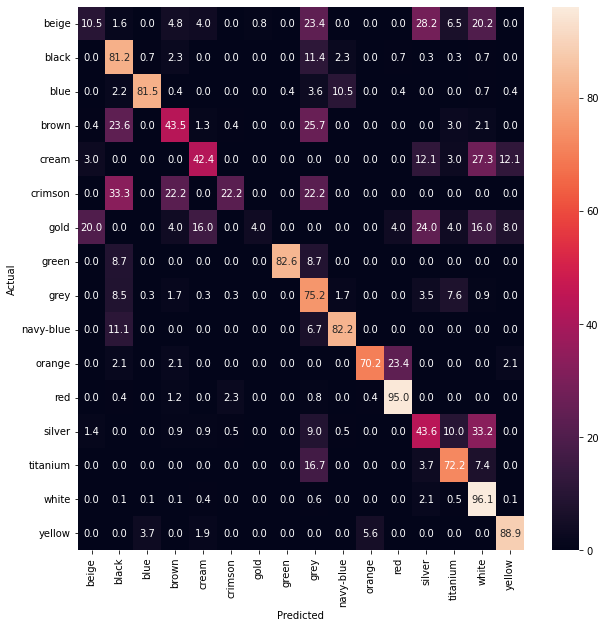

In [ ]:
analyzer.plot_confusion_mat()

In [ ]:
analyzer.evaluate_model()

# ***Second*** day

In [10]:
rgb_model = tf.keras.models.load_model('./drive/MyDrive/checkpoints/rgb-model-25.h5',
                                        custom_objects={'KerasLayer':hub.KerasLayer})

In [11]:
history = rgb_model.fit(train_ds,
                        callbacks=callbacks,
                        epochs=40,
                        initial_epoch=25,
                        class_weight=class_weight)

Epoch 26/40
533/533 [==============================] - 1177s 2s/step - loss: 47.0379 - auc: 0.8577 - accuracy: 0.9071
Epoch 27/40
533/533 [==============================] - 150s 279ms/step - loss: 38.3338 - auc: 0.8650 - accuracy: 0.9106
Epoch 28/40
533/533 [==============================] - 149s 278ms/step - loss: 35.9375 - auc: 0.8682 - accuracy: 0.9117
Epoch 29/40
533/533 [==============================] - 149s 278ms/step - loss: 33.5248 - auc: 0.8719 - accuracy: 0.9132
Epoch 30/40
533/533 [==============================] - 149s 278ms/step - loss: 28.8148 - auc: 0.8860 - accuracy: 0.9211
Epoch 31/40
533/533 [==============================] - 149s 278ms/step - loss: 25.7778 - auc: 0.8893 - accuracy: 0.9244
Epoch 32/40
533/533 [==============================] - 149s 277ms/step - loss: 27.0345 - auc: 0.8862 - accuracy: 0.9209
Epoch 33/40
533/533 [==============================] - 149s 278ms/step - loss: 23.6815 - auc: 0.8911 - accuracy: 0.9243
Epoch 34/40
533/533 [=====================

In [12]:
rgb_model.save('./drive/MyDrive/checkpoints/rgb-model-40.h5')

Making confusion matrix:


  0%|          | 0/55 [00:00<?, ?it/s]

Confusion matrix is saved


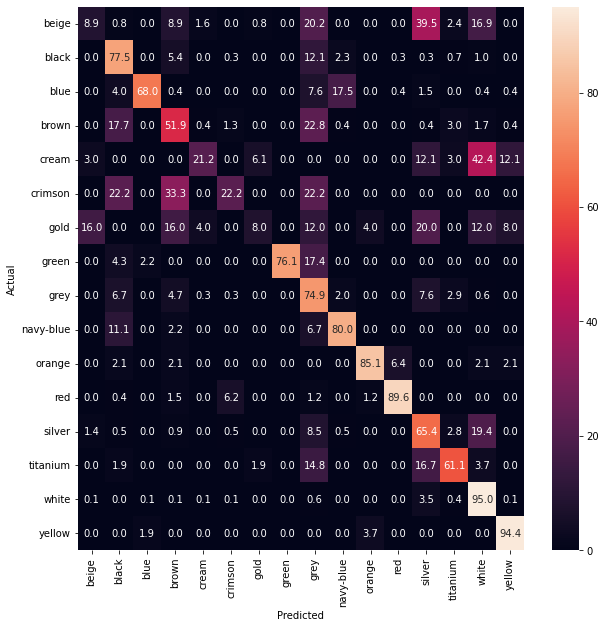

In [13]:
analyzer = ErrorAnalyzer(model=rgb_model,
                         model_name='RGB-model-2',
                         ds=val_ds,
                         classes=classes)

analyzer.plot_confusion_mat()

In [ ]:
analyzer.evaluate_model()

In [15]:
history = rgb_model.fit(train_ds,
                        callbacks=callbacks,
                        epochs=50,
                        initial_epoch=40,
                        class_weight=class_weight)

Epoch 41/50
533/533 [==============================] - 150s 279ms/step - loss: 12.6570 - auc: 0.9211 - accuracy: 0.9397
Epoch 42/50
533/533 [==============================] - 150s 279ms/step - loss: 12.3198 - auc: 0.9232 - accuracy: 0.9379
Epoch 43/50
533/533 [==============================] - 149s 278ms/step - loss: 10.7191 - auc: 0.9279 - accuracy: 0.9424
Epoch 44/50
533/533 [==============================] - 149s 277ms/step - loss: 10.8150 - auc: 0.9262 - accuracy: 0.9420
Epoch 45/50
533/533 [==============================] - 150s 279ms/step - loss: 10.3590 - auc: 0.9295 - accuracy: 0.9416
Epoch 46/50
533/533 [==============================] - 149s 278ms/step - loss: 10.1852 - auc: 0.9299 - accuracy: 0.9436
Epoch 47/50
533/533 [==============================] - 149s 278ms/step - loss: 8.7210 - auc: 0.9336 - accuracy: 0.9445
Epoch 48/50
533/533 [==============================] - 149s 277ms/step - loss: 9.5159 - auc: 0.9317 - accuracy: 0.9419
Epoch 49/50
533/533 [=====================

In [16]:
rgb_model.save('./drive/MyDrive/checkpoints/rgb-model-50.h5')

Making confusion matrix:


  0%|          | 0/55 [00:00<?, ?it/s]

Confusion matrix is saved


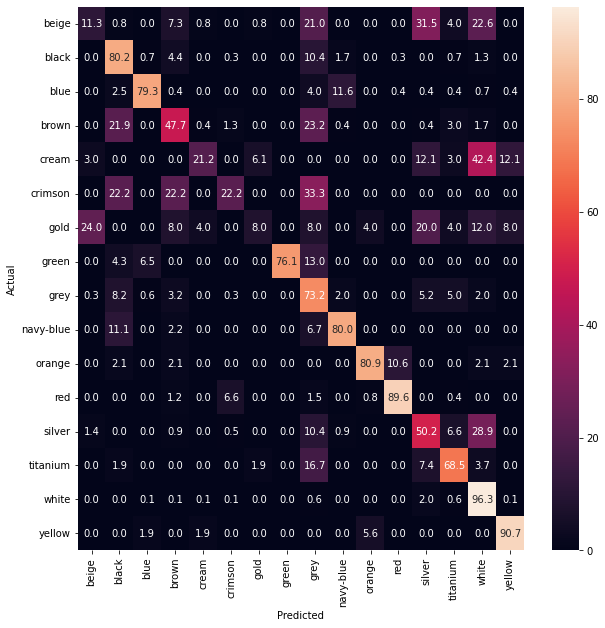

In [18]:
analyzer = ErrorAnalyzer(model=rgb_model,
                         model_name='RGB-model-3',
                         ds=val_ds,
                         classes=classes)

analyzer.plot_confusion_mat()


In [ ]:
analyzer.evaluate_model()

In [20]:
history = rgb_model.fit(train_ds,
                        callbacks=callbacks,
                        epochs=60,
                        initial_epoch=50,
                        class_weight=class_weight)

Epoch 51/60
533/533 [==============================] - 149s 278ms/step - loss: 8.9205 - auc: 0.9319 - accuracy: 0.9437
Epoch 52/60
533/533 [==============================] - 149s 277ms/step - loss: 9.0120 - auc: 0.9324 - accuracy: 0.9441
Epoch 53/60
533/533 [==============================] - 149s 278ms/step - loss: 8.6071 - auc: 0.9316 - accuracy: 0.9431
Epoch 54/60
533/533 [==============================] - 149s 278ms/step - loss: 8.3025 - auc: 0.9336 - accuracy: 0.9454
Epoch 55/60
533/533 [==============================] - 149s 278ms/step - loss: 8.0955 - auc: 0.9358 - accuracy: 0.9450
Epoch 56/60
533/533 [==============================] - 149s 278ms/step - loss: 7.7359 - auc: 0.9399 - accuracy: 0.9486
Epoch 57/60
533/533 [==============================] - 149s 278ms/step - loss: 7.9733 - auc: 0.9419 - accuracy: 0.9487
Epoch 58/60
533/533 [==============================] - 149s 278ms/step - loss: 7.6935 - auc: 0.9398 - accuracy: 0.9482
Epoch 59/60
533/533 [===========================

In [21]:
rgb_model.save('./drive/MyDrive/checkpoints/rgb-model-60.h5')

Making confusion matrix:


  0%|          | 0/55 [00:00<?, ?it/s]

Confusion matrix is saved


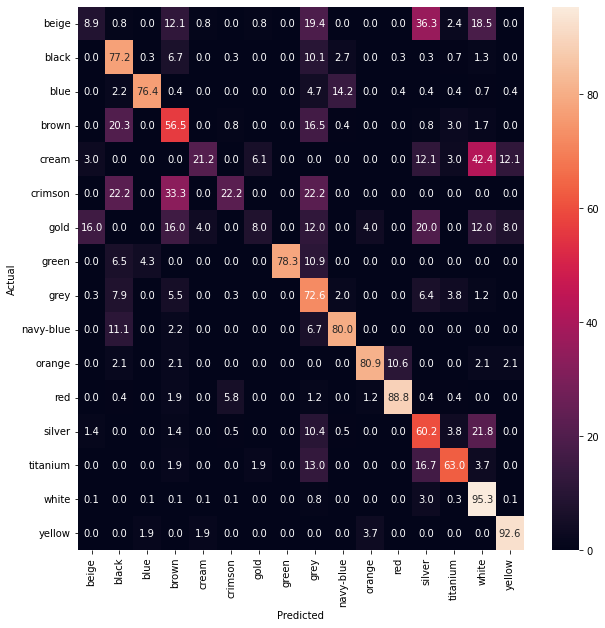

In [22]:
analyzer = ErrorAnalyzer(model=rgb_model,
                         model_name='RGB-model-4',
                         ds=val_ds,
                         classes=classes)

analyzer.plot_confusion_mat()


In [ ]:
analyzer.evaluate_model()